In [1]:
import os
from os import listdir, remove
from os.path import isfile, join
import numpy as np

## Download dataset

In [2]:
import wget

In [3]:
fname = "review_beauty.json.gz"

In [4]:
%%time
if not os.path.exists(fname):
    filename = wget.download("http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Beauty_5.json.gz")
    os.rename(filename, fname)

CPU times: user 15 µs, sys: 11 µs, total: 26 µs
Wall time: 28.8 µs


In [5]:
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [6]:
df = getDF(fname)

In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


## Word2Vec pretrained

In [8]:
from gensim.models import KeyedVectors
from google_drive_downloader import GoogleDriveDownloader as gdd

In [9]:
# if you already have pretrained wordvector weights, replace weightpath variable with a path of it
weight_dir = os.path.join(os.path.abspath('..'),"word2vec")
weight_path = os.path.join(weight_dir, "GoogleNews-vectors-negative300.bin")

In [10]:
if not os.path.exists(weight_dir):
    os.makedirs(weight_dir)
else:
    print("Directory is already exist")

Directory is already exist


In [11]:
if not os.path.isfile(weight_path):
    print("No pretrained weight file, start download...")
    gdd.download_file_from_google_drive(file_id='0B7XkCwpI5KDYNlNUTTlSS21pQmM',
                                        dest_path=weight_path + '.gz',
                                        unzip=False)
    inF = gzip.open(weight_path + '.gz', 'rb')
    outF = open(weight_path, 'wb')
    outF.write(inF.read())
    inF.close()
    outF.close()

    remove(w2v_path + '.gz')

    print("Done")
else:
    print("pretrained weight is already exist")


pretrained weight is already exist


In [12]:
# load pretrained vector
w2v = KeyedVectors.load_word2vec_format(weight_path, binary=True)

## preprocess

In [13]:
from collections import defaultdict
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import re
stops = stopwords.words('english')
re_sc = re.compile('[\!@#$%\^&\*\(\)-=\[\]\{\}\.,/\?~\+\'"|]')

import warnings
warnings.filterwarnings('ignore')

In [14]:
df['fulltext'] = df['summary'] +" " +  df['reviewText']

In [15]:
df = df[['fulltext','overall']]
df.head()

,fulltext,overall
0,Don't waste your money Very oily and creamy. N...,1.0
1,OK Palette! This palette was a decent price an...,3.0
2,great quality The texture of this concealer pa...,4.0
3,Do not work on my face I really can't tell wha...,2.0
4,It's okay. It was a little smaller than I expe...,3.0


In [16]:
# tokenize, except stopwords and punctuation
def text2words(text):
    text = re_sc.sub(' ', text).strip()
    words = word_tokenize(text)
    words = [word.lower() for word in words if word not in stops]
    return words

In [17]:
%%time
df['words'] = df['fulltext'].apply(text2words)
print(df['words'][0])

['don', 'waste', 'money', 'very', 'oily', 'creamy', 'not', 'i', 'expected', 'ordered', 'try', 'highlight', 'contour', 'looked', 'awful', 'plus', 'took', 'forever', 'arrive']
CPU times: user 1min 34s, sys: 1.01 s, total: 1min 35s
Wall time: 1min 35s


In [18]:
df['counts'] = df['words'].apply(len)
df.head()

,fulltext,overall,words,counts
0,Don't waste your money Very oily and creamy. N...,1.0,"[don, waste, money, very, oily, creamy, not, i...",19
1,OK Palette! This palette was a decent price an...,3.0,"[ok, palette, this, palette, decent, price, i,...",18
2,great quality The texture of this concealer pa...,4.0,"[great, quality, the, texture, concealer, pall...",51
3,Do not work on my face I really can't tell wha...,2.0,"[do, work, face, i, really, tell, exactly, thi...",25
4,It's okay. It was a little smaller than I expe...,3.0,"[it, okay, it, little, smaller, i, expected, o...",36


## decide max length of words

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

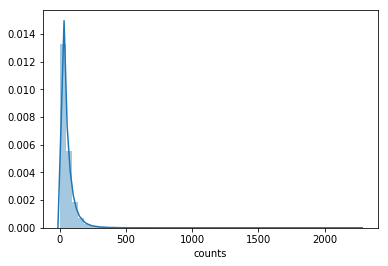

In [20]:
sns.distplot(df['counts'])

In [21]:
wordlen = 150
print("%s rows among %s rows have length more than %s" % (df[df['counts']>wordlen].count()[0], len(df), wordlen))

9619 rows among 198502 rows have length more than 150


## make vocabulary dict

In [22]:
wordcnt = defaultdict(lambda: 0)

In [23]:
%%time
for words in df['words']:
    for word in words:
        wordcnt[word] += 1

CPU times: user 1.88 s, sys: 8.07 ms, total: 1.89 s
Wall time: 1.89 s


In [24]:
sorted(wordcnt.items(), key=lambda kv:-kv[1])

[('i', 795236),
 ('hair', 174191),
 ('it', 130140),
 ('product', 122828),
 ('skin', 110015),
 ('use', 104320),
 ('like', 102140),
 ('great', 89068),
 ('the', 88495),
 ('this', 76952),
 ('love', 71258),
 ('good', 70299),
 ('one', 62666),
 ('really', 61913),
 ('using', 52102),
 ('well', 51965),
 ('would', 51343),
 ('used', 50695),
 ('get', 47597),
 ('face', 43979),
 ('color', 42063),
 ('dry', 41020),
 ('much', 40225),
 ('also', 39735),
 ('time', 39220),
 ('my', 38217),
 ('nice', 37746),
 ('little', 37347),
 ('products', 36277),
 ('works', 35909),
 ('even', 32132),
 ('long', 31009),
 ('smell', 30034),
 ('day', 29669),
 ('look', 28615),
 ('price', 28553),
 ('shampoo', 27972),
 ('make', 27827),
 ('better', 27809),
 ('oil', 27445),
 ('feel', 27257),
 ('brush', 27019),
 ('work', 26993),
 ('first', 25861),
 ('scent', 25439),
 ('soft', 23820),
 ('conditioner', 23817),
 ('try', 23761),
 ('tried', 23741),
 ('recommend', 23416),
 ('best', 23229),
 ('way', 22311),
 ('still', 22255),
 ('think', 2209

In [25]:
wordset = set(wordcnt.keys())
len(wordset)

76069

In [26]:
vocab_dict = {k+1:v for k, v in enumerate(wordset)}
vocab_dict[0] = "<PAD>"
vocab_dict_inv = {v:k for k,v in vocab_dict.items()}

In [27]:
# make w2v matrix for our dataset's words
weights = np.array([w2v[v] if v in w2v else np.zeros(w2v.vector_size) for i ,v in vocab_dict.items()])
# (number of words, dimension of wordvectors)
weights.shape

(76070, 300)

## make X, y array

In [28]:
def words2indexarray(words):
    indexarray = np.zeros([wordlen], dtype=np.int64)
    for i in range(min(wordlen, len(words))):
        indexarray[i] = vocab_dict_inv[words[i]]
    return indexarray
words2indexarray(df['words'].values[0])

array([51661, 58479,  3327, 34985, 35590, 26371, 71946, 27724,     8,
       15408, 62227, 18651, 10436, 62929, 44817, 33941, 47865, 26505,
       60316,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [29]:
X = list(map(words2indexarray, df['words'].values))
X[:2]

[array([51661, 58479,  3327, 34985, 35590, 26371, 71946, 27724,     8,
        15408, 62227, 18651, 10436, 62929, 44817, 33941, 47865, 26505,
        60316,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [30]:
# apply normalization on score from 1 ~ 5 to 0.0 ~ 1.0
y = np.array(df['overall'].values) -1
y = y /4.0
y = y.reshape([-1, 1])
min(y), max(y)

(array([0.]), array([1.]))

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## model

In [32]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution(device_policy=tfe.DEVICE_PLACEMENT_SILENT)

In [33]:
from cnn_sentence import CNN_regression_single

In [ ]:
device = 'gpu:0' if tfe.num_gpus() > 0 else 'cpu:0'

In [34]:
cnn_regression = CNN_regression_single(
    num_words=len(vocab_dict), in_dim=wordlen, out_dim=1, is_static=False, device_name=device)
cnn_regression.copy_pretrained(weights)
cnn_regression(tf.convert_to_tensor(X_train[:1]), True)
cnn_regression.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  22821000  
_________________________________________________________________
conv11 (Conv1D)              multiple                  90100     
_________________________________________________________________
conv12 (Conv1D)              multiple                  120100    
_________________________________________________________________
conv13 (Conv1D)              multiple                  150100    
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
out (Dense)                  multiple                  301       
Total para

In [35]:
# if you get OOM error, use smaller batch_size
cnn_regression.fit(X_train, y_train, X_val, y_val, epochs=10, verbose=2, batch_size=1024, tqdm_option="normal")

VAL     1: 100%|██████████| 32/32 [00:13<00:00,  1.19it/s]


[EPOCH 1 / STEP 1]
TRAIN loss   : 59.3373
VAL   loss   : 40.7529


VAL     2: 100%|██████████| 32/32 [00:12<00:00,  1.17it/s]


[EPOCH 2 / STEP 2]
TRAIN loss   : 34.2928
VAL   loss   : 36.2928


VAL     4: 100%|██████████| 32/32 [00:13<00:00,  1.15it/s]


[EPOCH 4 / STEP 4]
TRAIN loss   : 20.9297
VAL   loss   : 34.8779


VAL     6: 100%|██████████| 32/32 [00:12<00:00,  1.23it/s]


[EPOCH 6 / STEP 6]
TRAIN loss   : 12.9459
VAL   loss   : 35.6973


VAL     8: 100%|██████████| 32/32 [00:12<00:00,  1.21it/s]


[EPOCH 8 / STEP 8]
TRAIN loss   : 8.6642
VAL   loss   : 37.1444


VAL    10: 100%|██████████| 32/32 [00:12<00:00,  1.21it/s]


[EPOCH 10 / STEP 10]
TRAIN loss   : 6.6317
VAL   loss   : 37.1490


In [55]:
logits = cnn_regression(tf.convert_to_tensor(X_train[200:210]), False)
logits = logits.numpy()*4. + 1
real = y_train[200:210]*4. +1

In [56]:
for i in range(len(logits)):
    print("PRED:%.2f / REAL:%.2f" % (logits[i], real[i]))

PRED:4.85 / REAL:5.00
PRED:4.28 / REAL:5.00
PRED:4.97 / REAL:5.00
PRED:4.70 / REAL:5.00
PRED:2.73 / REAL:3.00
PRED:2.99 / REAL:3.00
PRED:4.81 / REAL:5.00
PRED:4.53 / REAL:5.00
PRED:4.13 / REAL:4.00
PRED:2.48 / REAL:3.00


In [59]:
logits = cnn_regression(tf.convert_to_tensor(X_test[50:60]), False)
logits = logits.numpy()*4. + 1
real = y_test[50:60]*4. +1

In [60]:
for i in range(len(logits)):
    print("PRED:%.2f / REAL:%.2f" % (logits[i], real[i]))

PRED:4.89 / REAL:5.00
PRED:4.90 / REAL:5.00
PRED:4.39 / REAL:4.00
PRED:3.66 / REAL:4.00
PRED:4.90 / REAL:5.00
PRED:4.95 / REAL:5.00
PRED:3.69 / REAL:2.00
PRED:4.41 / REAL:5.00
PRED:2.94 / REAL:3.00
PRED:4.41 / REAL:5.00
